# Preparing the Data

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.4 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/alexzhao/miniconda3/envs/env_stat214/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/alexzhao/miniconda3/envs/env_stat214/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/alexzhao/miniconda3/envs/env_stat214/lib/python3.11/site-packages/ipykernel/kernelapp.py", 

In [ ]:
# Load dataset
labeled_imgs = ["O013257", "O013490", "O012791"]

embedding_filename = ["27","39","30"]

filepath = "../data/"
embedding_filepath = "../data/embeddings/"
all_data = []
for i,labeled_img in enumerate(labeled_imgs):
    # npz_data = np.load(filepath + labeled_img+".npz")
    # img_data = pd.DataFrame(npz_data["arr_0"])
    img_data = pd.read_csv(filepath + labeled_img + ".csv", header=0, index_col=None)
    # img_data.columns = ["y", "x","NDAI","SD","CORR","DF","CF","BF","AF","AN","label"]
    autoencoder_embeddings = pd.read_csv(embedding_filepath + "image"+embedding_filename[i]+ "_ae.csv", header=0, index_col=None)
    # print(autoencoder_embeddings[:2])
    # print(img_data[:2])

    #merge autoencoder data 
    merged_data = pd.merge(autoencoder_embeddings, img_data, on=["x", "y"], how="inner")
    # Keep only rows with valid labels
    merged_data = merged_data[(merged_data["label"] == 1) | (merged_data["label"] == -1)] 
    merged_data["img_name"] = labeled_img
    all_data.append(merged_data)

df = pd.concat(all_data,axis=0)
print(df[:2])
# df = pd.read_csv("../data/all_data.csv") # Dataset with selected and newly created features




# selected_features = ["SD", "NDAI", "AN", "grad_feature"] # Keep only selected features. Update this line if new features are added

selected_features = ["SD", "NDAI", "CORR", "grad_feature","ae0","ae1","ae2","ae3","ae4","ae5","ae6","ae7"] 
# X = df[selected_features].to_numpy()
# y = df[["label"]].to_numpy().flatten()
loc = df[["x", "y"]].to_numpy() # Location data

     y     x       ae0       ae1       ae2       ae3       ae4       ae5  \
1  2.0  71.0  0.179080 -1.867973  3.327708 -2.068531  1.639938 -1.666549   
2  2.0  72.0  1.455453 -1.707663  3.000144 -0.871549  1.592336 -3.335439   

        ae6       ae7  ...           SD      CORR        DF       CF  \
1  4.291027 -1.349104  ...  1169.416504  0.473416  23461.00  18388.5   
2  3.665110 -0.528406  ...  1376.460571  0.861363  23831.75  16752.5   

         BF       AF       AN  label  grad_feature  img_name  
1  11575.25  8993.25  5978.75    1.0    365.572037   O013257  
2  12560.25  9570.75  6900.00    1.0    351.231571   O013257  

[2 rows x 21 columns]


# Part A: Classification with 3 Different Models

In [ ]:
(df[df.img_name == "O013257"].shape[0]+df[df.img_name == "O013490"].shape[0])/(df[df.img_name == "O013257"].shape[0]+df[df.img_name == "O013490"].shape[0]+df[df.img_name == "O012791"].shape[0])

0.7363573386931536

In [ ]:
# Split data so that 2 images using as training set and 1 imageas testing set 
X_train = df[df.img_name != "O012791"][selected_features].to_numpy()
X_test = df[df.img_name == "O012791"][selected_features].to_numpy()
y_train = df[df.img_name != "O012791"][["label"]].to_numpy().flatten()
y_test = df[df.img_name == "O012791"][["label"]].to_numpy().flatten()
# X_train, X_test, y_train, y_test, loc_train, loc_test = train_test_split(X, y, loc, test_size=0.2, stratify=y, random_state=1)

In [ ]:
len(X_train)==len(y_train)

True

In [ ]:
df["label"].value_counts()

label
-1.0    124078
 1.0     80904
Name: count, dtype: int64

In [ ]:
df["label"].shape[0] == len(y_test)+len(y_train)

True

In [ ]:
print(df[df.img_name != "O012791"]["label"].value_counts())
print(df[df.img_name == "O012791"]["label"].value_counts())

label
-1.0    91280
 1.0    59660
Name: count, dtype: int64
label
-1.0    32798
 1.0    21244
Name: count, dtype: int64


In [ ]:
# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)  # Standardize test data with respect to train data

In [ ]:
# Model 1: Random Forest

# 1.1 Test Assumptions

# Assumption 1: We have enought labeled samples to train our classifier
print("Testing assumption 1: sufficient training data:")
print(f"    Number of samples in training set: {len(X_train)}")
print(f"    Number of samples in testing set: {len(X_test)}")
if len(X_train) >= 10000:
    print("    There are sufficient training data for the model to generalize")
else:
    print("    There is not sufficient training data for the model to generalize")
print()

# Assumption 2: We have a balanced distribution between cloud and non-cloud samples
print("Testing assumption 2: balanced outcome distribution:")
cloud_train = np.sum(y_train == 1) / len(y_train)
non_cloud_train = np.sum(y_train == -1) / len(y_train)
cloud_test = np.sum(y_test == 1) / len(y_test)
non_cloud_test = np.sum(y_test == -1) / len(y_test)
print(f"    Proportion of cloud samples in training set: {cloud_train:.2f}")
print(f"    Proportion of non-cloud samples in training set: {non_cloud_train:.2f}")
print(f"    Proportion of cloud samples in testing set: {cloud_test:.2f}")
print(f"    Proportion of non-cloud samples in training set: {non_cloud_test:.2f}")
if np.allclose([cloud_train, cloud_test], 0.5, atol=0.1):
    print("    Outcome distribution is balanced")
else:
    print("    Outcome distribution is not balanced, so we have to use class weighting in our model")

Testing assumption 1: sufficient training data:
    Number of samples in training set: 150940
    Number of samples in testing set: 54042
    There are sufficient training data for the model to generalize

Testing assumption 2: balanced outcome distribution:
    Proportion of cloud samples in training set: 0.40
    Proportion of non-cloud samples in training set: 0.60
    Proportion of cloud samples in testing set: 0.39
    Proportion of non-cloud samples in training set: 0.61
    Outcome distribution is not balanced, so we have to use class weighting in our model


In [ ]:
# 1.2 Train model

# Train random forest model with class weighting
# Use 100 trees and parallelize across CPU cores
# rf_model = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=1, class_weight="balanced", n_jobs=-1)

# from imblearn.over_sampling import SMOTE
# smote = SMOTE(sampling_strategy='auto', random_state=42)
# X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=1, class_weight="balanced", n_jobs=-1,min_samples_split=50)

# rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_split=50, n_jobs=-1, random_state=1)

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'max_depth': [5, 10, 15,20],
    'min_samples_split': [20,50,100],
    'max_features': ['sqrt', 'log2'],
    'n_estimators': [50, 100, 200]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42,class_weight="balanced",n_jobs=-1), param_grid, cv=5)
grid_search.fit(X_train, y_train)

rf_model = grid_search.best_estimator_

Accuracy on test set: 0.8440

ROC-AUC on test set: 0.9300

5-fold cross-validation accuracy: 0.9488

Classification report:
              precision    recall  f1-score   support

        -1.0       0.87      0.87      0.87     32798
         1.0       0.80      0.81      0.80     21244

    accuracy                           0.84     54042
   macro avg       0.84      0.84      0.84     54042
weighted avg       0.84      0.84      0.84     54042



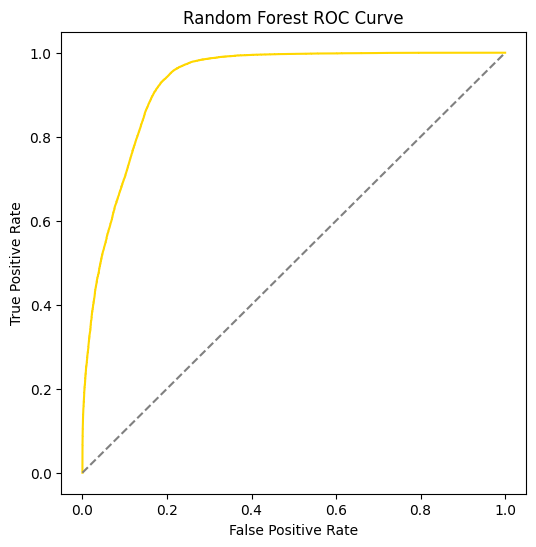

In [ ]:
# 1.3 Evaluate model performance

# Predict on testing set
rf_y_hat = rf_model.predict(X_test)

# Get prediction accuracy on testing set
rf_accuracy = accuracy_score(y_test, rf_y_hat)
print(f"Accuracy on test set: {rf_accuracy:.4f}")
print()

# Get ROC-AUC
rf_y_prob = rf_model.predict_proba(X_test)[:, 1]  # Get confidence scores for the positive class
rf_roc_auc = roc_auc_score(y_test, rf_y_prob)
print(f"ROC-AUC on test set: {rf_roc_auc:.4f}")
print()

# Get cross-validation accuracy on training set
rf_cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring="accuracy")
rf_mean_cv_score = rf_cv_scores.mean()
print(f"5-fold cross-validation accuracy: {rf_mean_cv_score:.4f}")
print()

# Get comprehensive classification report
print("Classification report:")
print(classification_report(y_test, rf_y_hat))

# Plot ROC Curve
y_test_binary = (y_test == 1).astype(int) # convert (1, -1) to (1, 0) representation
rf_fpr, rf_tpr, _ = roc_curve(y_test_binary, rf_y_prob)
plt.figure(figsize=(6, 6))
plt.plot(rf_fpr, rf_tpr, color="gold")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--") # random guess (0.5 AUC) line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest ROC Curve")
plt.show()

In [ ]:
# Model 2: Multi-Layer Perceptron

# 2.1 Test Assumptions

# Assumption 1: We have enought labeled samples to train our classifier
print("Testing assumption 1: sufficient training data:")
if len(X_train) >= 10000:
    print("    There are sufficient training data for the model to generalize")
else:
    print("    There is not sufficient training data for the model to generalize")
print()

# Assumption 2: Spatial relations are already captured
print("Testing assumption 2: no additional spatial information needed:")
print("    MLP can work because the autoencoder embeddings already encode spatial context from 9×9 patches, making CNN unnecessary.")
print("    If the input contains sufficient spatial information, an MLP can classify pixels efficiently without need for convolution.")
print()

# Assumption 3: We have a balanced distribution between cloud and non-cloud samples
print("Testing assumption 3: balanced outcome distribution:")
if np.allclose([cloud_train, cloud_test], 0.5, atol=0.1):
    print("    Outcome distribution is balanced")
else:
    print("    Outcome distribution is not balanced, so we have to use class weighting in our model")
print()

# Assumption 4: Features are properly standardized
print("Testing assumption 4: standardized features:")
X_train_mean = np.mean(X_train, axis=0)
X_train_std = np.std(X_train, axis=0)
if np.allclose(X_train_mean, 0, atol=1e-2) and np.allclose(X_train_std, 1, atol=1e-2):
    print("    Features are properly standardized")
else:
    print("    Features are not properly standardized")

Testing assumption 1: sufficient training data:
    There are sufficient training data for the model to generalize

Testing assumption 2: no additional spatial information needed:
    MLP can work because the autoencoder embeddings already encode spatial context from 9×9 patches, making CNN unnecessary.
    If the input contains sufficient spatial information, an MLP can classify pixels efficiently without need for convolution.

Testing assumption 3: balanced outcome distribution:
    Outcome distribution is not balanced, so we have to use class weighting in our model

Testing assumption 4: standardized features:
    Features are properly standardized


In [ ]:
# 2.2 Train Model

# Convert X and y to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor((y_train == 1).astype(float), dtype=torch.float32).unsqueeze(1) # Convert to (0, 1) representation
y_test_tensor = torch.tensor((y_test == 1).astype(float), dtype=torch.float32).unsqueeze(1)

# Compute class weights to account for imbalanced outcome distribution
y_train_binary = (y_train == 1).astype(int)
class_weights = compute_class_weight("balanced", classes=np.array([0, 1]), y=y_train_binary) # Weight for negative and positive class respectively
pos_weight = torch.tensor([class_weights[1]], dtype=torch.float32) # Get weight for positive class

# MLP Classifier
class MLPClassifier(nn.Module):
    def __init__(self, input_size=8, hidden_size=64): # Change later to accomodate new features
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size), # Hidden layer 1
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size), # Hidden layer 2
            nn.ReLU(),
            nn.Linear(hidden_size, 1), # Output layer
        )
    def forward(self, x):
        return self.model(x)

# Initialize model
nn_model = MLPClassifier(input_size=X_train.shape[1])
optimizer = optim.Adam(nn_model.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)  # Binary Cross Entropy loss with raw logits input and class weighting

# Train model
epochs = 1000
train_losses = [] # Record loss for each epoch for graphing
for epoch in tqdm(range(epochs), desc="Training"):
    optimizer.zero_grad() # Clear gradients at the start of each iteration
    epoch_y_hat = nn_model(X_train_tensor) # Forward pass
    loss = criterion(epoch_y_hat, y_train_tensor) # Compute loss
    loss.backward() # Back propagation
    optimizer.step() # Update model weights
    train_losses.append(loss.item()) # Append current loss to loss records

Training: 100%|██████████| 1000/1000 [01:45<00:00,  9.45it/s]


Accuracy on Test Set: 0.7968

ROC-AUC on test set: 0.9111

Classification report:
              precision    recall  f1-score   support

           0       0.78      0.92      0.85     32798
           1       0.83      0.61      0.70     21244

    accuracy                           0.80     54042
   macro avg       0.81      0.76      0.77     54042
weighted avg       0.80      0.80      0.79     54042



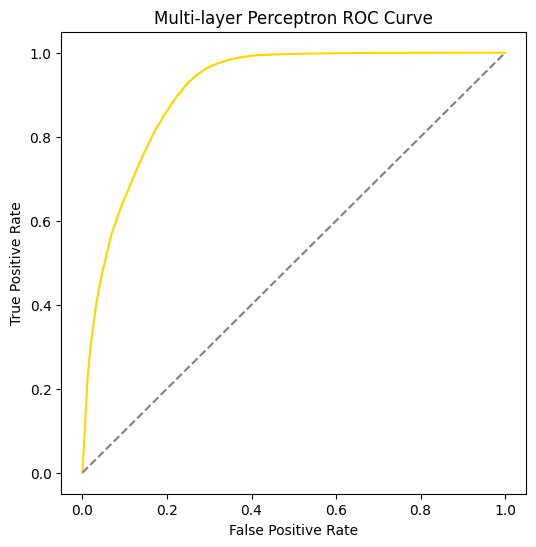

In [ ]:
# 2.3 Evaluate model performance

# Predict on testing set
nn_model.eval()
with torch.no_grad():
    nn_logits = nn_model(X_test_tensor) # Get raw output logits
    nn_y_prob = torch.sigmoid(nn_logits)
    nn_y_prob = np.array(nn_y_prob.tolist()).flatten()
    nn_y_hat = (nn_y_prob > 0.5).astype(int) # Convert to binary classication result

# Get prediction accuracy on testing set
y_test_binary = (y_test == 1).astype(int)
accuracy = (nn_y_hat == y_test_binary).mean()
print(f"Accuracy on Test Set: {accuracy:.4f}")
print()

# Get ROC-AUC
nn_roc_auc = roc_auc_score(y_test_binary, nn_y_prob)
print(f"ROC-AUC on test set: {nn_roc_auc:.4f}")
print()

# Get comprehensive classification report
print("Classification report:")
print(classification_report(y_test_binary, nn_y_hat))

# Plot ROC Curve
nn_fpr, nn_tpr, _ = roc_curve(y_test_binary, nn_y_prob)
plt.figure(figsize=(6, 6))
plt.plot(nn_fpr, nn_tpr, color="gold")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--") # random guess (0.5 AUC) line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-layer Perceptron ROC Curve")
plt.show()

In [ ]:
# Model 3: Support Vector Machine

# 3.1 Test Assumptions

# Assumption 1: We have enought labeled samples to train our classifier
print("Testing assumption 1: sufficient training data:")
if len(X_train) >= 10000:
    print("    There are sufficient training data for the model to generalize")
else:
    print("    There is not sufficient training data for the model to generalize")
print()

# Assumption 2: We have a balanced distribution between cloud and non-cloud samples
print("Testing assumption 2: balanced outcome distribution:")
if np.allclose([cloud_train, cloud_test], 0.5, atol=0.1):
    print("    Outcome distribution is balanced")
else:
    print("    Outcome distribution is not balanced, so we have to use class weighting in our model")
print()

# Assumption 3: Features are properly standardized
print("Testing assumption 3: standardized features:")
if np.allclose(X_train_mean, 0, atol=1e-2) and np.allclose(X_train_std, 1, atol=1e-2):
    print("    Features are properly standardized")
else:
    print("    Features are not properly standardized")

In [ ]:
# 3.2 Train model

# SVM model with RBF kernel for non-linear classification and class weighting
svm_model = SVC(kernel="rbf", class_weight="balanced", probability=True)
svm_model.fit(X_train, y_train_binary)

SVC(class_weight='balanced', probability=True)

In [ ]:
# 3.3 Evaluate model performance

# Predict on testing set
svm_y_hat = svm_model.predict(X_test)
svm_y_prob = svm_model.predict_proba(X_test)[:, 1]

# Get prediction accuracy on testing set
svm_accuracy = accuracy_score(y_test_binary, svm_y_hat)
print(f"Accuracy on test set: {svm_accuracy:.4f}")
print()

# Get ROC-AUC
svm_roc_auc = roc_auc_score(y_test_binary, svm_y_prob)
print(f"ROC-AUC on test set: {svm_roc_auc:.4f}")
print()

# Get cross-validation accuracy on training set
svm_cv_scores = cross_val_score(svm_model, X_train, y_train_binary, cv=5, scoring="accuracy")
svm_mean_cv_score = svm_cv_scores.mean()
print(f"5-fold cross-validation accuracy: {svm_mean_cv_score:.4f}")
print()

# Get comprehensive classification report
print("Classification report:")
print(classification_report(y_test_binary, svm_y_hat))

# Plot ROC Curve
svm_fpr, svm_tpr, _ = roc_curve(y_test_binary, svm_y_prob)
plt.figure(figsize=(6, 6))
plt.plot(svm_fpr, svm_tpr, color="gold")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--") # random guess (0.5 AUC) line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Support Vector Machine ROC Curve")
plt.show()

# Part B: Analysis of Convergence and Feature Importance for Random Forest Model

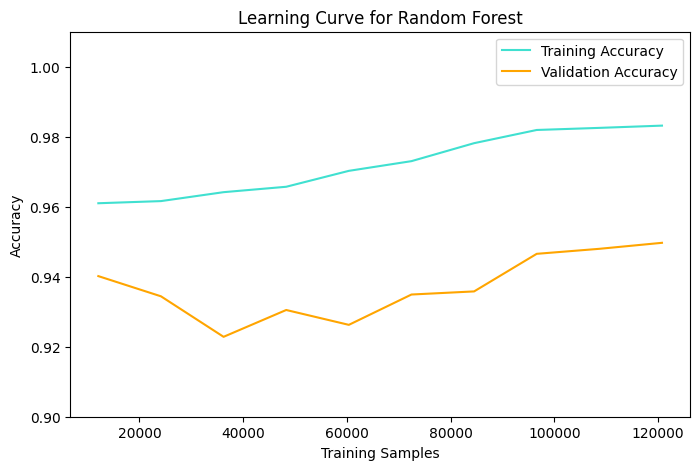

In [26]:
# Test 1: Model Performance - Learning Curve
# We train the model with an increasingly large subset of the data to evaluate the model's performanceas more data is fed in, using cross-validated accuracy as the metric
# High training accuracy but low validation accuracy as sample size goes up ➡️ overfitting
# Low training accuracy ➡️ underfitting
# Training accuracy and validation accuracy are comparably high ➡️ good model

# Train models with 10-100% of the data
#rf_model = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=1, class_weight="balanced", n_jobs=-1)
train_sizes, train_scores, test_scores = learning_curve(
    rf_model, X_train, y_train, cv=5, scoring="accuracy", n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

# Compute mean cross validation scores
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, color="turquoise", label="Training Accuracy")
plt.plot(train_sizes, test_mean, color="orange", label="Validation Accuracy")
plt.xlabel("Training Samples")
plt.ylabel("Accuracy")
plt.ylim(0.9, 1.01)
plt.title("Learning Curve for Random Forest")
plt.legend()
plt.show()

Testing different models: 100%|██████████| 20/20 [04:57<00:00, 14.86s/it]


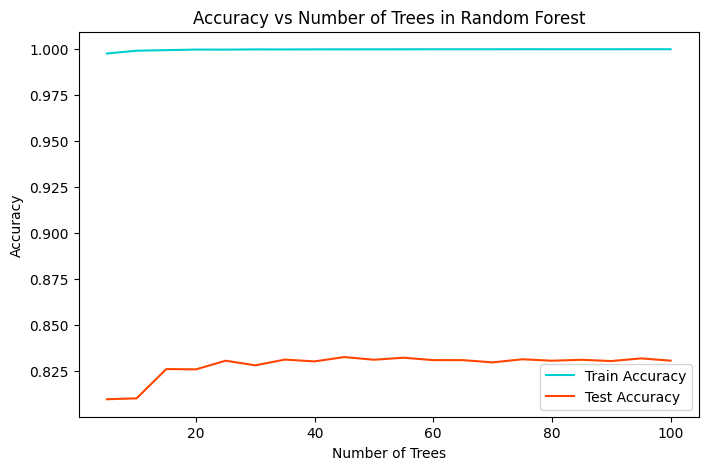

In [27]:
# Test 2: Parameter Estimation - Convergence Analysis
# We train multiple random forest models with increasing number of trees to see whether having more trees improves performance
# Train and test accuracy keep increasing as more trees are added ➡️ demand more trees
# Train and test accuracy plateaus after a certain number of trees ➡️ performance bottleneck, stop adding more trees

# Compare train and test accuracy
train_accuracy = []
test_accuracy = []

# Our original model uses 100 trees, but we test models with 5-100 trees here
for n in tqdm(range(5, 105, 5), desc="Testing different models"):
    rf_model_it = RandomForestClassifier(n_estimators=n, class_weight="balanced", random_state=1, n_jobs=-1) # Model with n trees
    rf_model_it.fit(X_train, y_train) # Train model
    train_accuracy.append(accuracy_score(y_train, rf_model_it.predict(X_train))) # Get accuracy on train set
    test_accuracy.append(accuracy_score(y_test, rf_model_it.predict(X_test))) # Get accuracy on test set

# Plot training and testing accuracy as a function of number of trees
plt.figure(figsize=(8, 5))
plt.plot(range(5, 105, 5), train_accuracy, color="darkturquoise", label="Train Accuracy")
plt.plot(range(5, 105, 5), test_accuracy, color="orangered", label="Test Accuracy")
plt.xlabel("Number of Trees")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of Trees in Random Forest")
plt.legend()
plt.show()

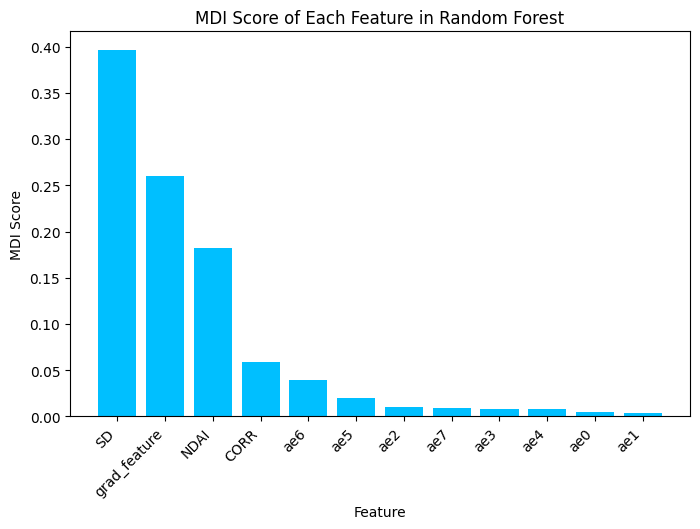

In [28]:
# Test 3: Feature Importance with MDI

# Train Random Forest model
#rf_model = RandomForestClassifier(n_estimators=100, # class_weight="balanced", random_state=1, n_jobs=-1)
# rf_model.fit(X_train, y_train)

# Get feature importance
feature_importances = rf_model.feature_importances_ # Calculate MDIs
sorted_importance_index = np.argsort(feature_importances)[::-1] # Sort by decreasing order

# Plot importance score of each feature
plt.figure(figsize=(8, 5))
plt.bar(range(X_train.shape[1]), feature_importances[sorted_importance_index], color="deepskyblue", align="center")
plt.xticks(range(X_train.shape[1]), np.array(selected_features)[sorted_importance_index], rotation=45, ha="right")
plt.xlabel("Feature")
plt.ylabel("MDI Score")
plt.title("MDI Score of Each Feature in Random Forest")
plt.show()

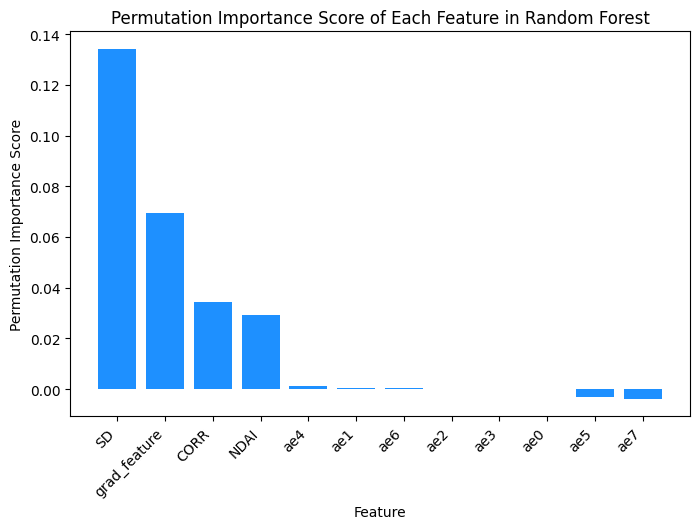

In [29]:
# Test 4: Feature Permutation Importance

# Compute permutation importances
perm_importances = permutation_importance(rf_model, X_test, y_test, n_repeats=10, random_state=1)
sorted_perm_index = perm_importances.importances_mean.argsort()[::-1]

# Plot permutation importance score of each feature
plt.figure(figsize=(8, 5))
plt.bar(range(X_train.shape[1]), perm_importances.importances_mean[sorted_perm_index], color="dodgerblue", align="center")
plt.xticks(range(X_train.shape[1]), np.array(selected_features)[sorted_perm_index], rotation=45, ha="right")
plt.xlabel("Feature")
plt.ylabel("Permutation Importance Score")
plt.title("Permutation Importance Score of Each Feature in Random Forest")
plt.show()

# Part C: Ad-Hoc EDA

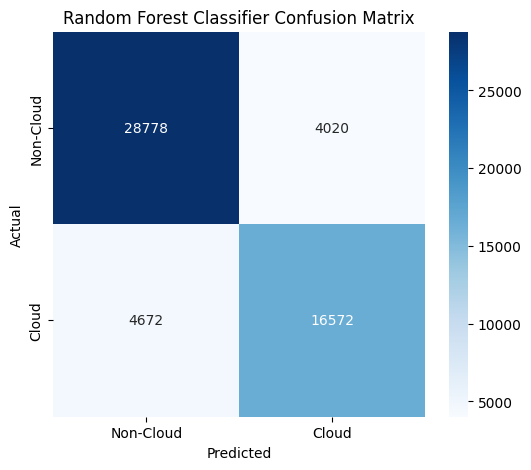

In [30]:
# 1. Confusion Matrix
# Clearly visualizes false positives and false negatives

# Fit model on test set
rf_y_hat = rf_model.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, rf_y_hat)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Cloud", "Cloud"], yticklabels=["Non-Cloud", "Cloud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Classifier Confusion Matrix")
plt.show()

In [31]:
# 2. Comprehensive Classification Report
# Precision = TP / (TP + FP)
# Recall = TP / (TP + FN)

print("Classification report:")
print(classification_report(y_test, rf_y_hat))

Classification report:
              precision    recall  f1-score   support

        -1.0       0.86      0.88      0.87     32798
         1.0       0.80      0.78      0.79     21244

    accuracy                           0.84     54042
   macro avg       0.83      0.83      0.83     54042
weighted avg       0.84      0.84      0.84     54042



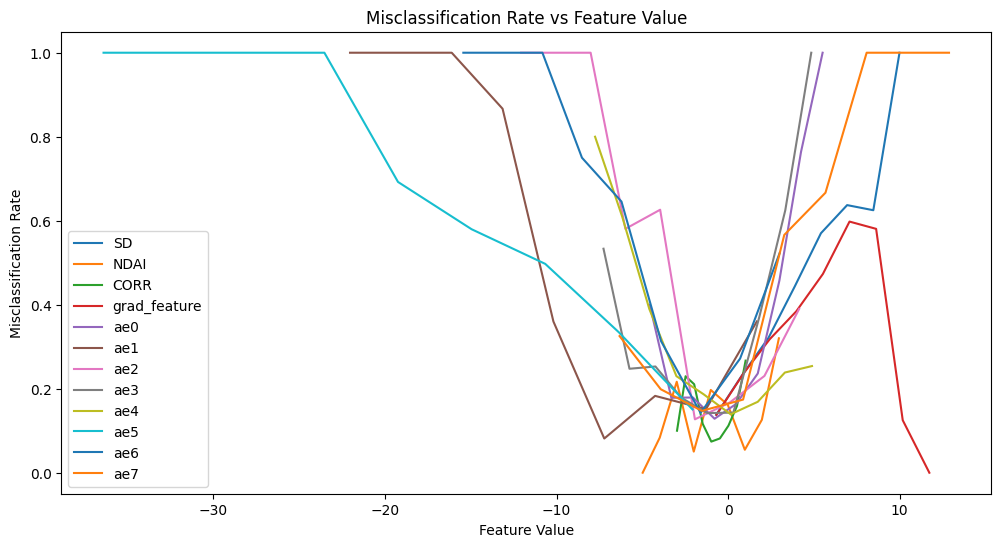

In [32]:
# 3. Distribution of Misclassified Points - By Feature

# Create a dataframe documenting misclassified points
df_errors = pd.DataFrame(X_test, columns=selected_features)
df_errors["Actual"] = y_test
df_errors["Predicted"] = rf_y_hat
df_errors["Is_Misclassified"] = df_errors["Actual"] != df_errors["Predicted"]

plt.figure(figsize=(12, 6))

# Plot misclassification rates against values of the features
for feature_index in range(X_test.shape[1]):
    feature_values = X_test[:, feature_index] # Get range of feature values
    bins = np.linspace(feature_values.min(), feature_values.max(), 10)  # Create 20 bins for each feature
    error_rates = [np.mean(df_errors["Is_Misclassified"][np.digitize(feature_values, bins) == i]) for i in range(1, len(bins))] # Calculate misclassification rate in each bin
    plt.plot(bins[:-1], error_rates, label=selected_features[feature_index]) # Plot misclassification rate

plt.xlabel("Feature Value")
plt.ylabel("Misclassification Rate")
plt.legend()
plt.title("Misclassification Rate vs Feature Value")
plt.show()

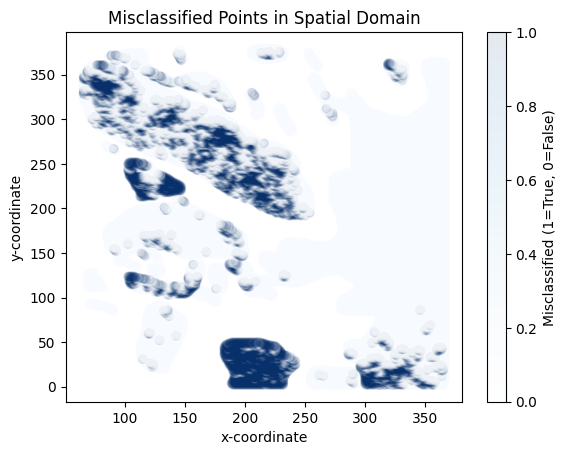

In [37]:
# 4. Distribution of Misclassified Points - By Spatial Location
# Dark blue dots - misclassified points
# Light blue regions - correctly classified points

# Plot correctly and incorrectly classified points by spatial location
plt.scatter(loc_test[:, 0], loc_test[:, 1], c=df_errors["Is_Misclassified"], cmap="Blues", alpha=0.1)
plt.xlabel("x-coordinate")
plt.ylabel("y-coordinate")
plt.title("Misclassified Points in Spatial Domain")
plt.colorbar(label="Misclassified (1=True, 0=False)")
plt.show()

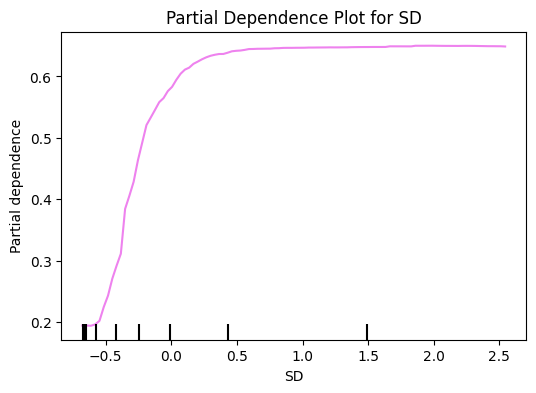

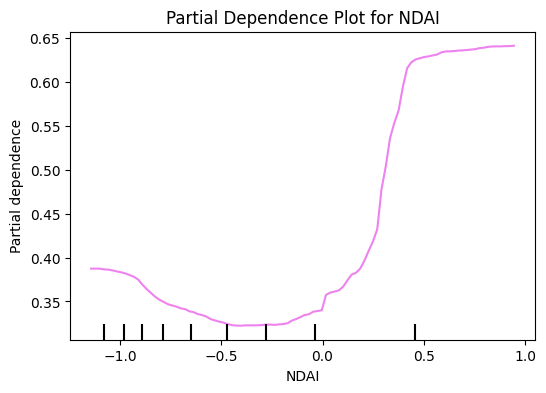

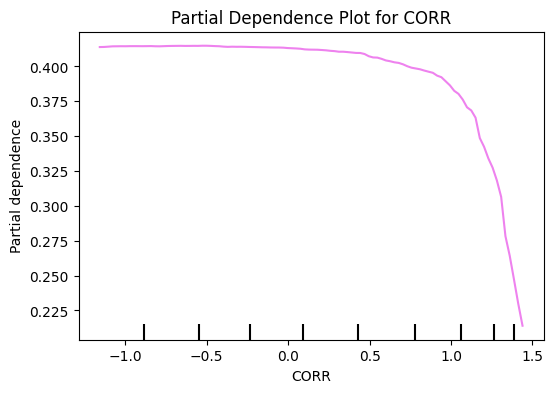

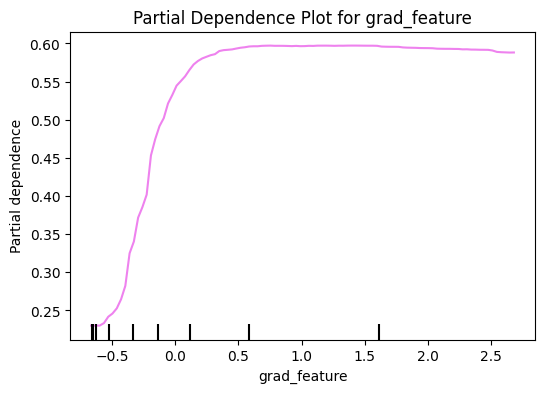

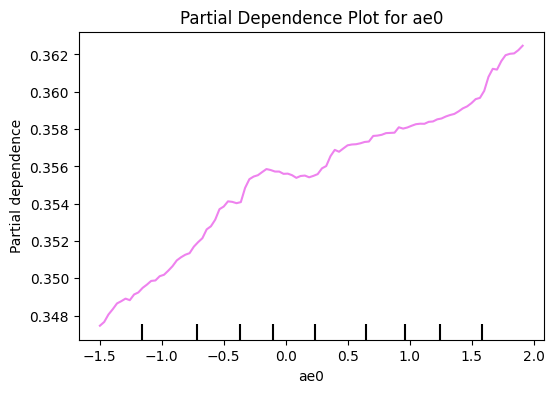

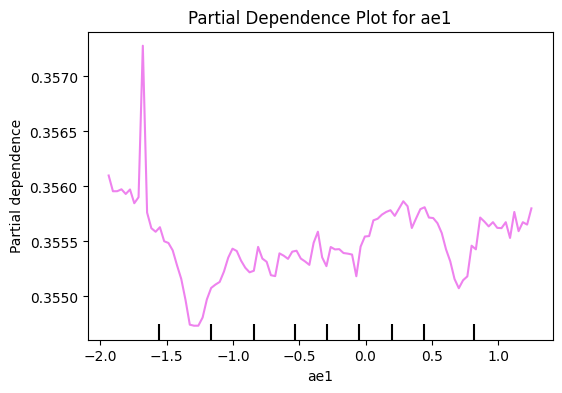

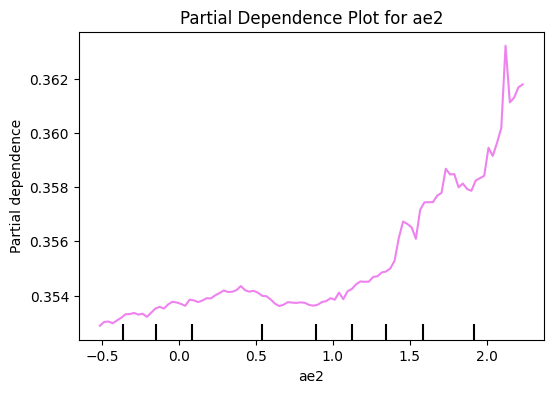

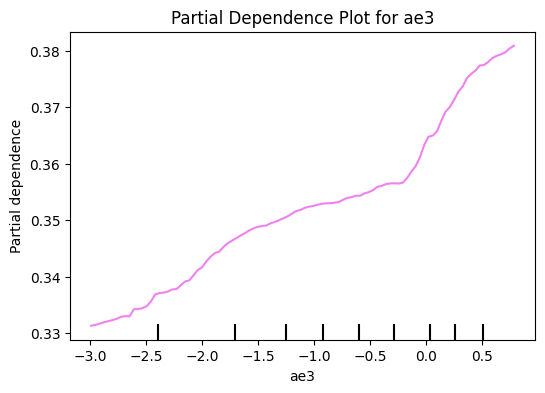

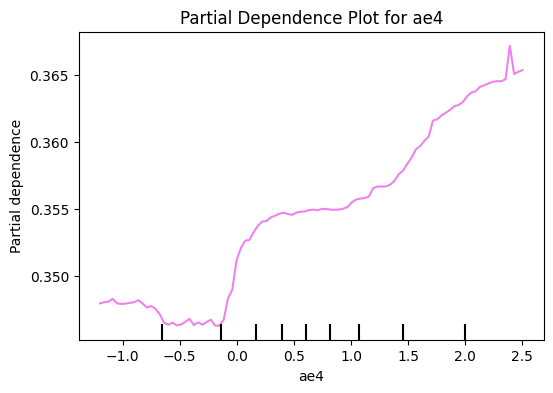

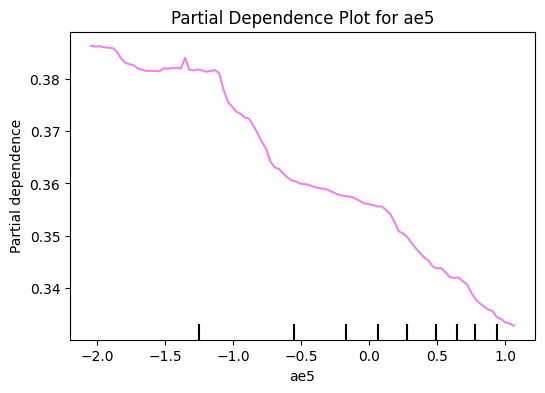

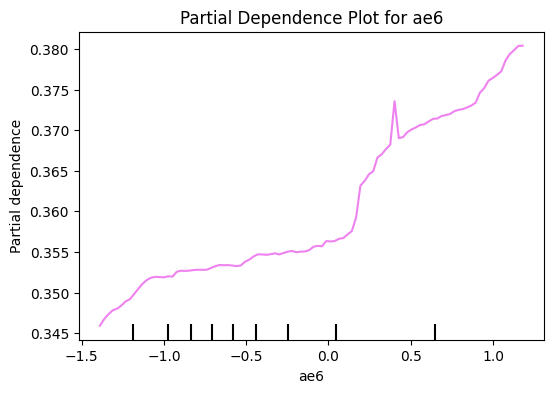

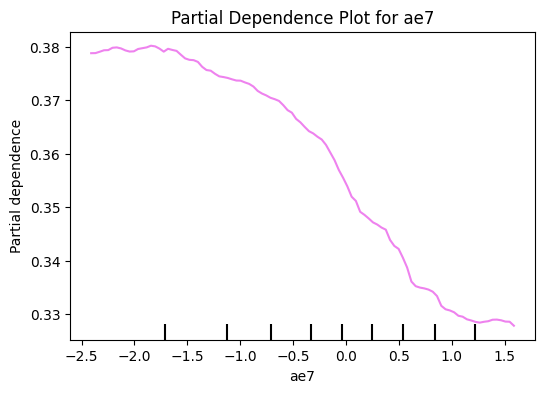

In [38]:
# 5. Partial Dependence Plots
# Measures the impact of a single feature on the model prediction while keeping all others constant

# Partial dependence plot for each feature
color = {"color": "violet"}
for feature_index in range(X_test.shape[1]):
    fig, ax = plt.subplots(figsize=(6, 4))
    PartialDependenceDisplay.from_estimator(rf_model, X_test, [feature_index], feature_names=selected_features, line_kw=color, ax=ax)
    ax.set_title(f"Partial Dependence Plot for {selected_features[feature_index]}")
plt.show()

In [39]:
# 6. Visual Check
# Compare the predicted and actual outcomes visually to see if cloud regions match

from matplotlib.colors import ListedColormap, BoundaryNorm
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning, message="Mean of empty slice")

def load_data(file_name):
    filepath = "../data/image_data/"
    npz_data = np.load(filepath + file_name+".npz")
    img_data = npz_data["arr_0"]
    df_image = pd.DataFrame(img_data,columns = ["y","x","NDAI","SD","CORR",
                                                "DF","CF","BF","AF","AN","label"])
    return df_image

def compute_gradient(A):
    A_padded = np.pad(A, pad_width=1, mode='constant', constant_values=np.nan)
    diffs = []
    for dy in [-1, 0, 1]:
        for dx in [-1, 0, 1]:
            if dy == 0 and dx == 0:
                continue
            neighbor = A_padded[1+dy : 1+dy+A.shape[0], 1+dx : 1+dx+A.shape[1]]
            diff = np.abs(A - neighbor)
            diffs.append(diff)
    diffs = np.stack(diffs, axis=0)
    grad = np.nanmean(diffs, axis=0)
    return grad

def compute_grad_feature_for_group(df_group):
    new_feature = None
    channels = ["SD", "NDAI", "AN"]
    grad_dict = {}
    for channel in channels:
        pivot = df_group.pivot(index="y", columns="x", values=channel)
        A = pivot.values.astype(float)
        grad = compute_gradient(A)
        grad_df = pd.DataFrame(grad, index=pivot.index, columns=pivot.columns)
        grad_series = grad_df.stack().rename(channel)
        grad_dict[channel] = grad_series

    grad_all = pd.concat(grad_dict, axis=1)
    grad_mean = grad_all.mean(axis=1).rename("grad_feature")
    df_group = df_group.merge(grad_mean.reset_index(), on=["y", "x"], how="left")
    return df_group

def plot_image(image_data, labeled = True, ax=None):
    if labeled:
        df_image = pd.DataFrame(image_data,columns = ["y","x","SD","NDAI","AN","grad_feature","label"])
    else:
        print("unlabeled")
    
    plot_df = pd.pivot_table(df_image, index = "y", columns = "x", values = "label")
    plot_df.sort_values(by="y",ascending=True,inplace=True)

    colors = ["lightskyblue", "whitesmoke", "steelblue"]  # Define specific colors
    cmap = ListedColormap(colors)
    # Define boundaries for each color (must be one more than the number of colors)
    bounds = [-1, 0, 1, 2]  # -1→notclound->gray, 0→unlabel->black, 1→cloud->white
    norm = BoundaryNorm(bounds, cmap.N)
    # fig, ax = plt.subplots()

    img = ax.imshow(plot_df,cmap=cmap,norm=norm)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
   
    cbar = plt.colorbar(img, ticks=[-0.5, 0.5, 1.5])  # Tick positions (center of each range)
    cbar.set_ticklabels(['NotCloud', 'Unlabeled', 'Cloud'])  # Set corresponding labels

data = load_data("O013257")
data = compute_grad_feature_for_group(data)
X_image = data[selected_features].to_numpy()
y_image = data[["label"]].to_numpy()
loc_image = data[["y", "x"]].to_numpy()
merged = np.concatenate((loc_image, X_image, y_image), axis=1)
fig, axs = plt.subplots(1, 2, figsize=(12, 5)) 
axs[0].set_title("Actual Cloud Distribution")
plot_image(merged, True, axs[0])
X_image_norm = scaler.transform(X_image)
y_hat_image = rf_model.predict(X_image_norm)
y_hat_image[y_image.flatten() == 0] = 0
predicted = np.concatenate((loc_image, X_image, y_hat_image.reshape(-1, 1)), axis=1)
axs[1].set_title("Predicted Cloud Distribution")
plot_image(predicted, True, axs[1])

KeyError: "['ae0', 'ae1', 'ae2', 'ae3', 'ae4', 'ae5', 'ae6', 'ae7'] not in index"

In [ ]:
# 7. Stability Check
# Make perturbations to the original data to verify the robustness of our algorithm

# Test 1: Re-split training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, #test_size=0.2, stratify=y, random_state=2) # Split with different random seed
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train) # Standardize again
#X_test = scaler.transform(X_test)
#rf_model = RandomForestClassifier(n_estimators=100, #class_weight="balanced", random_state=1, n_jobs=-1)
#rf_model.fit(X_train, y_train) # Train model on new training set

# y_hat = rf_model.predict(X_test) # Predict on new testing set
# accuracy = accuracy_score(y_test, y_hat) # Get accuracy score
# print(f"Accuracy with different split: {accuracy:.4f}")
# y_prob = rf_model.predict_proba(X_test)[:, 1]
# roc_auc = roc_auc_score(y_test, y_prob) # Get ROC-AUC
# print(f"ROC-AUC with different split: {roc_auc:.4f}")
# print()

# Test 2: Add noise to features
X_test_noisy = X_test + np.random.normal(loc=0, scale=0.05, size=X_test.shape) # Add random noise to features in testing set
y_hat_noisy = rf_model.predict(X_test_noisy) # Predict on noisy input
noisy_accuracy = accuracy_score(y_test, y_hat_noisy) # Get accuracy score for perturbed predictions
print(f"Accuracy with perturbed input: {noisy_accuracy:.4f}")
noisy_y_prob = rf_model.predict_proba(X_test_noisy)[:, 1]
noisy_roc_auc = roc_auc_score(y_test, noisy_y_prob) # Get ROC-AUC for perturbed predictions
print(f"ROC-AUC with perturbed input: {noisy_roc_auc:.4f}")
print()

Accuracy with different split: 0.9417
ROC-AUC with different split: 0.9880

Accuracy with perturbed input: 0.9393
ROC-AUC with perturbed input: 0.9866



KeyError: "['ae0', 'ae1', 'ae2', 'ae3', 'ae4', 'ae5', 'ae6', 'ae7'] not in index"

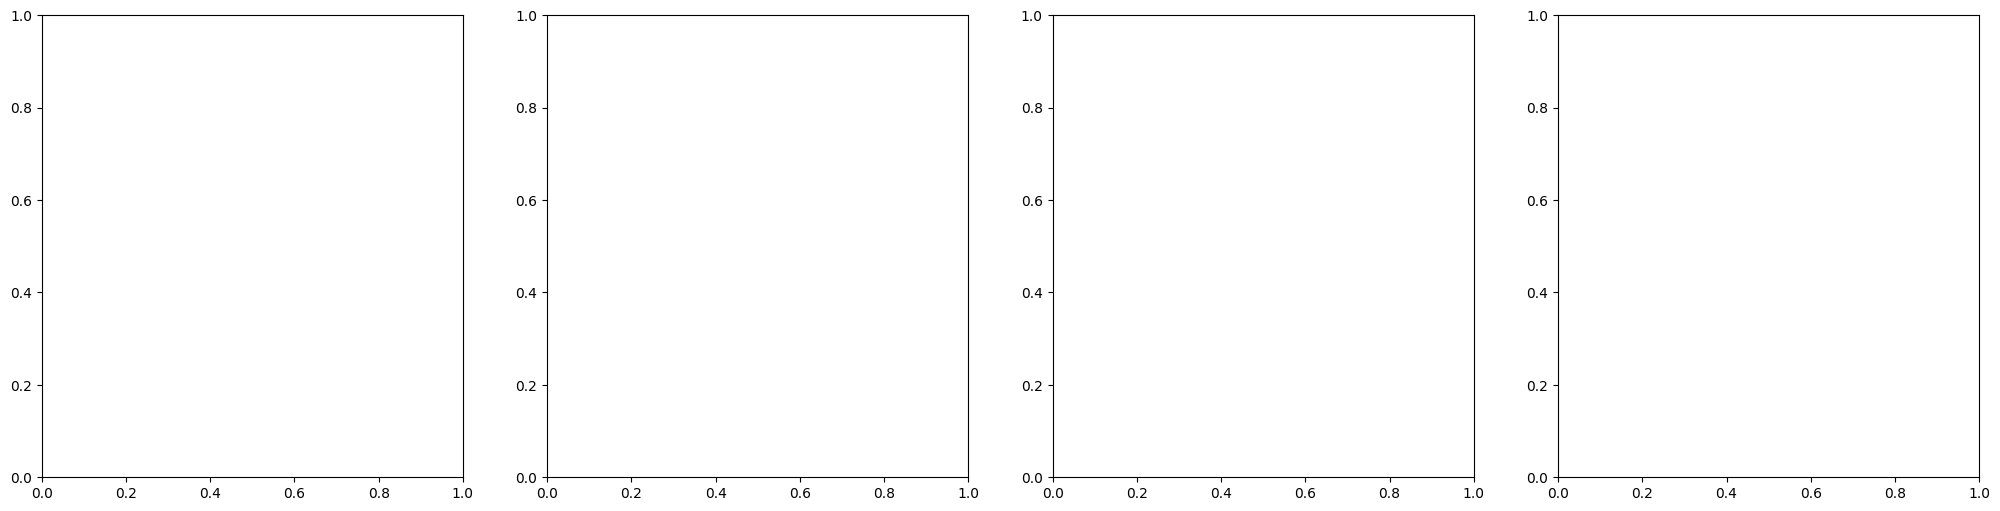

In [40]:
# 8. Visual check on unlabeled images
# Run the classifier on 2 unlabeled images and check if the outcome looks reasonable

from matplotlib.colors import ListedColormap, BoundaryNorm
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning, message="Mean of empty slice")

def load_data(file_name):
    filepath = "../data/image_data/"
    npz_data = np.load(filepath + file_name+".npz")
    img_data = npz_data["arr_0"]
    df_image = pd.DataFrame(img_data,columns = ["y","x","NDAI","SD","CORR",
                                                "DF","CF","BF","AF","AN"])
    return df_image

def compute_gradient(A):
    A_padded = np.pad(A, pad_width=1, mode='constant', constant_values=np.nan)
    diffs = []
    for dy in [-1, 0, 1]:
        for dx in [-1, 0, 1]:
            if dy == 0 and dx == 0:
                continue
            neighbor = A_padded[1+dy : 1+dy+A.shape[0], 1+dx : 1+dx+A.shape[1]]
            diff = np.abs(A - neighbor)
            diffs.append(diff)
    diffs = np.stack(diffs, axis=0)
    grad = np.nanmean(diffs, axis=0)
    return grad

def compute_grad_feature_for_group(df_group):
    new_feature = None
    channels = ["SD", "NDAI", "AN"]
    grad_dict = {}
    for channel in channels:
        pivot = df_group.pivot(index="y", columns="x", values=channel)
        A = pivot.values.astype(float)
        grad = compute_gradient(A)
        grad_df = pd.DataFrame(grad, index=pivot.index, columns=pivot.columns)
        grad_series = grad_df.stack().rename(channel)
        grad_dict[channel] = grad_series

    grad_all = pd.concat(grad_dict, axis=1)
    grad_mean = grad_all.mean(axis=1).rename("grad_feature")
    df_group = df_group.merge(grad_mean.reset_index(), on=["y", "x"], how="left")
    return df_group

def plot_image(image_data, labeled = True, ax=None):
    if labeled:
        df_image = pd.DataFrame(image_data,columns = ["y","x","SD","NDAI","AN","grad_feature","label"])
    else:
        print("unlabeled")
    
    plot_df = pd.pivot_table(df_image, index = "y", columns = "x", values = "label")
    plot_df.sort_values(by="y",ascending=True,inplace=True)

    colors = ["lightskyblue", "whitesmoke", "steelblue"]  # Define specific colors
    cmap = ListedColormap(colors)
    # Define boundaries for each color (must be one more than the number of colors)
    bounds = [-1, 0, 1, 2]  # -1→notclound->gray, 0→unlabel->black, 1→cloud->white
    norm = BoundaryNorm(bounds, cmap.N)
    # fig, ax = plt.subplots()

    img = ax.imshow(plot_df,cmap=cmap,norm=norm)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
   
    cbar = plt.colorbar(img, ticks=[-0.5, 0.5, 1.5])  # Tick positions (center of each range)
    cbar.set_ticklabels(['NotCloud', '', 'Cloud'])  # Set corresponding labels

images = ["O013024", "O007898", "O049838", "O051236"]
fig, axs = plt.subplots(1, 4, figsize=(25, 6))
for i in range(4):
    image = images[i]
    data = load_data(image)
    data = compute_grad_feature_for_group(data)
    X_image = data[selected_features].to_numpy()
    loc_image = data[["y", "x"]].to_numpy()
    X_image_norm = scaler.transform(X_image)
    y_hat_image = rf_model.predict(X_image_norm)
    predicted = np.concatenate((loc_image, X_image, y_hat_image.reshape(-1, 1)), axis=1)
    axs[i].set_title(f"Predicted Cloud Distribution for {image}")
    plot_image(predicted, True, axs[i])